# Initial set-up/Preparation

There are 4 bits that have been updated,

* the S&P 500 price was converted into monthly by taking the average(old), additional analysis was conducted to show that there's a low descrepancy between the mean and median (meaning there aren't any significant mean-skewing datapoints) so it is ok to use either mean or median to represent S&P 500 monthly price changes.

* the linear regression model parameters were flipped, we predicted S&P 500 using inflation from 9 months in the future, that has been corrected (in order to get meaning values with flipped parameters, standardization of values had to be done)

* linear regression prediction part added and R^2 computed for test sample

* also added a block to describe the time horizon for the data
---
Additionally, 2 graphs have been added containing the linear regression line with the scatter of data points from the test and train samples respectively.

In [1]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats


In [2]:
#import the data
stock_data = pd.read_csv('./../Stock Market Dataset.csv')
inflation_data = pd.read_csv('./../SeriesReport-20240324235202_f3e23e.csv')

#check the data
stock_data.info()
print()
inflation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1243 non-null   int64  
 1   Date               1243 non-null   object 
 2   Natural_Gas_Price  1243 non-null   float64
 3   Natural_Gas_Vol.   1239 non-null   float64
 4   Crude_oil_Price    1243 non-null   float64
 5   Crude_oil_Vol.     1220 non-null   float64
 6   Copper_Price       1243 non-null   float64
 7   Copper_Vol.        1206 non-null   float64
 8   Bitcoin_Price      1243 non-null   object 
 9   Bitcoin_Vol.       1243 non-null   float64
 10  Platinum_Price     1243 non-null   object 
 11  Platinum_Vol.      636 non-null    float64
 12  Ethereum_Price     1243 non-null   object 
 13  Ethereum_Vol.      1243 non-null   float64
 14  S&P_500_Price      1243 non-null   object 
 15  Nasdaq_100_Price   1243 non-null   object 
 16  Nasdaq_100_Vol.    1242 

In [3]:
#corrections to data types

# drop the unnamed column if it exists
if 'Unnamed: 0' in stock_data.columns:
    stock_data = stock_data.drop('Unnamed: 0', axis=1)

# print the columns that are object data types
print(stock_data.dtypes[stock_data.dtypes == 'object'])

#change the object data types to float
stock_data['Bitcoin_Price'] = stock_data['Bitcoin_Price'].str.replace(',', '').astype(float)
stock_data['Platinum_Price'] = stock_data['Platinum_Price'].str.replace(',', '').astype(float)
stock_data['Gold_Price'] = stock_data['Gold_Price'].str.replace(',', '').astype(float)
stock_data['Ethereum_Price'] = stock_data['Ethereum_Price'].str.replace(',', '').astype(float)
stock_data['S&P_500_Price'] = stock_data['S&P_500_Price'].str.replace(',', '').astype(float)
stock_data['Nasdaq_100_Price'] = stock_data['Nasdaq_100_Price'].str.replace(',', '').astype(float)
stock_data['Berkshire_Price'] = stock_data['Berkshire_Price'].str.replace(',', '').astype(float)

stock_data.dtypes

Date                object
Bitcoin_Price       object
Platinum_Price      object
Ethereum_Price      object
S&P_500_Price       object
Nasdaq_100_Price    object
Berkshire_Price     object
Gold_Price          object
dtype: object


Date                  object
Natural_Gas_Price    float64
Natural_Gas_Vol.     float64
Crude_oil_Price      float64
Crude_oil_Vol.       float64
Copper_Price         float64
Copper_Vol.          float64
Bitcoin_Price        float64
Bitcoin_Vol.         float64
Platinum_Price       float64
Platinum_Vol.        float64
Ethereum_Price       float64
Ethereum_Vol.        float64
S&P_500_Price        float64
Nasdaq_100_Price     float64
Nasdaq_100_Vol.      float64
Apple_Price          float64
Apple_Vol.           float64
Tesla_Price          float64
Tesla_Vol.           float64
Microsoft_Price      float64
Microsoft_Vol.       float64
Silver_Price         float64
Silver_Vol.          float64
Google_Price         float64
Google_Vol.          float64
Nvidia_Price         float64
Nvidia_Vol.          float64
Berkshire_Price      float64
Berkshire_Vol.       float64
Netflix_Price        float64
Netflix_Vol.         float64
Amazon_Price         float64
Amazon_Vol.          float64
Meta_Price    

In [4]:
#convert date to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%d-%m-%Y')

#set date as index
stock_data = stock_data.set_index('Date')

In [5]:
#fix inflation data

#drop the last 2 columns
inflation_data = inflation_data.drop(inflation_data.columns[-2:], axis=1)

#change column names to their respective months

inflation_data.columns = ['Year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

#melt

inflation_data = pd.melt(inflation_data, id_vars='Year', var_name='Month', value_name='Infaltion Rate')

#change month and year to datetime
inflation_data['Month'] = inflation_data['Month'].astype(int)
inflation_data['Year'] = inflation_data['Year'].astype(int)
inflation_data['Month'] = inflation_data['Month'].apply(lambda x: '{0:0>2}'.format(x))
inflation_data['Year'] = inflation_data['Year'].astype(str)
inflation_data['Month'] = inflation_data['Month'].astype(str)
inflation_data['Date'] = inflation_data['Year'] + '-' + inflation_data['Month']
inflation_data['Date'] = pd.to_datetime(inflation_data['Date'])

#sort
inflation_data = inflation_data.sort_values(by=['Year', 'Month'])
inflation_data.drop(['Year', 'Month'], axis=1, inplace=True)

#set date as index
inflation_data = inflation_data.set_index('Date')

inflation_data.head()


,Infaltion Rate
Date,
2014-01-01,1.6
2014-02-01,1.6
2014-03-01,1.7
2014-04-01,1.8
2014-05-01,2.0


# Part I: Explore and describe your data.
## A: Describe

In this section, first we go over data types of both datasets, then we use DataFrame.describe() to get a look at general statistics. we specifically display the statistics for our column-of-interest (S&P_500_price) and then also do the same for inflation data

descriptions of these columns (what the data means) should be present in the paper submitted with this Notebook.

Finally, we display the percentage of missing values from each column and verify that our column-of-interest has no missing values.

In [6]:
print('time horizon for stock data',str(stock_data.index.min()).split(" ")[0], "to", str(stock_data.index.max()).split(" ")[0])

time horizon for stock data 2019-02-04 to 2024-02-02


In [7]:
#check the data
stock_data.info()
print()
inflation_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1243 entries, 2024-02-02 to 2019-02-04
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Natural_Gas_Price  1243 non-null   float64
 1   Natural_Gas_Vol.   1239 non-null   float64
 2   Crude_oil_Price    1243 non-null   float64
 3   Crude_oil_Vol.     1220 non-null   float64
 4   Copper_Price       1243 non-null   float64
 5   Copper_Vol.        1206 non-null   float64
 6   Bitcoin_Price      1243 non-null   float64
 7   Bitcoin_Vol.       1243 non-null   float64
 8   Platinum_Price     1243 non-null   float64
 9   Platinum_Vol.      636 non-null    float64
 10  Ethereum_Price     1243 non-null   float64
 11  Ethereum_Vol.      1243 non-null   float64
 12  S&P_500_Price      1243 non-null   float64
 13  Nasdaq_100_Price   1243 non-null   float64
 14  Nasdaq_100_Vol.    1242 non-null   float64
 15  Apple_Price        1243 non-null   float64
 16  Apple_

In [8]:
stock_data.describe().round(2)


,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,Platinum_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
count,1243.00,1239.00,1243.00,1220.00,1243.00,1206.00,1243.00,1.243000e+03,1243.00,636.00,...,1243.00,1243.00,1243.00,1.243000e+03,1243.00,1.243000e+03,1243.00,1.243000e+03,1243.00,1241.00
mean,3.49,131624.12,67.58,398903.78,3.54,35406.62,25241.90,4.033918e+07,959.00,9082.52,...,404273.05,2426.52,404.84,7.057401e+06,128.68,7.413005e+07,239.73,2.325851e+07,1759.25,211127.67
std,1.82,64385.14,20.47,216161.89,0.70,38415.45,16029.01,2.940889e+08,108.01,8876.54,...,86369.90,2660.50,114.99,6.384187e+06,30.81,3.245753e+07,71.02,1.555486e+07,203.26,115006.35
min,1.48,1200.00,-37.63,17020.00,2.10,10.00,3397.70,2.600000e+02,595.20,0.00,...,240000.00,80.00,166.37,1.140000e+06,79.41,1.763000e+07,88.91,5.470000e+06,1272.00,0.00
25%,2.35,91900.00,55.10,283597.50,2.86,370.00,10014.60,7.907500e+04,889.78,1120.00,...,318984.50,345.00,323.01,3.990000e+06,96.26,5.264500e+07,183.36,1.478500e+07,1669.60,152200.00
50%,2.70,127370.00,69.23,366885.00,3.67,10180.00,23055.10,2.153100e+05,944.70,6070.00,...,418349.00,1510.00,384.15,5.610000e+06,128.73,6.520000e+07,224.43,1.934000e+07,1804.20,197970.00
75%,4.06,169460.00,80.46,507242.50,4.14,68340.00,37784.20,6.151050e+05,1020.40,15287.50,...,471500.00,3225.00,495.36,7.910000e+06,158.11,8.674500e+07,301.65,2.711500e+07,1912.80,257920.00
max,9.65,381970.00,123.70,1770000.00,4.94,176040.00,67527.90,4.470000e+09,1297.10,42830.00,...,589498.00,13850.00,691.69,1.333900e+08,186.57,3.113500e+08,474.99,2.304100e+08,2089.70,813410.00


In [9]:
#describe the stock we're interested in
stock_data['S&P_500_Price'].describe().round(2)

count    1243.00
mean     3793.32
std       632.32
min      2237.40
25%      3190.64
50%      3932.69
75%      4349.24
max      4958.61
Name: S&P_500_Price, dtype: float64

In [10]:
#describe the inflation data
inflation_data.describe().round(2)

,Infaltion Rate
count,122.00
mean,2.83
std,1.54
min,1.20
25%,1.80
50%,2.20
75%,3.90
max,6.60


In [11]:
# display the percentage of missing values in each column in stock data

missing_values = stock_data.isnull().mean() * 100

missing_values_formatted = missing_values.map(lambda x: f"{x:.2f}%")

missing_values_formatted


Natural_Gas_Price     0.00%
Natural_Gas_Vol.      0.32%
Crude_oil_Price       0.00%
Crude_oil_Vol.        1.85%
Copper_Price          0.00%
Copper_Vol.           2.98%
Bitcoin_Price         0.00%
Bitcoin_Vol.          0.00%
Platinum_Price        0.00%
Platinum_Vol.        48.83%
Ethereum_Price        0.00%
Ethereum_Vol.         0.00%
S&P_500_Price         0.00%
Nasdaq_100_Price      0.00%
Nasdaq_100_Vol.       0.08%
Apple_Price           0.00%
Apple_Vol.            0.00%
Tesla_Price           0.00%
Tesla_Vol.            0.00%
Microsoft_Price       0.00%
Microsoft_Vol.        0.00%
Silver_Price          0.00%
Silver_Vol.           3.78%
Google_Price          0.00%
Google_Vol.           0.00%
Nvidia_Price          0.00%
Nvidia_Vol.           0.00%
Berkshire_Price       0.00%
Berkshire_Vol.        0.00%
Netflix_Price         0.00%
Netflix_Vol.          0.00%
Amazon_Price          0.00%
Amazon_Vol.           0.00%
Meta_Price            0.00%
Meta_Vol.             0.00%
Gold_Price          

## B: Explore

Firstly, we will measure the [volatility](https://www.investopedia.com/terms/v/volatility.asp) of the prices on the list, paying special attention to the ranking of the S&P500. The S&P500 stands for the Standard & Poor 500 and it's a "market-capitalization-weighted index of 500 leading publicly traded companies in the U.S." ([investopedia-S&P500](https://www.investopedia.com/terms/s/sp500.asp))

The choice of the S&P500 is down to it's low volatility and it being a good statistic to measure the U.S. market movements.

After that, we will merge the S&P500 price with the U.S. inflation data into one dataframe to explore them.

Then, we'll have to add new entries to the combined dataframe containing standardized values for both columns and % changes. 

Finally, we'll put the data into charts to get an intuition of it's behaviour and underlying relationships.

In [12]:
# volatility

#get a df containing only the prices, (dropping the volumnes)

price_data = stock_data[['Natural_Gas_Price', 'Crude_oil_Price', 'Copper_Price', 'Bitcoin_Price', 'Platinum_Price', 'Ethereum_Price', 'S&P_500_Price',
                      'Nasdaq_100_Price', 'Apple_Price', 'Tesla_Price', 'Microsoft_Price', 'Silver_Price', 'Google_Price', 'Nvidia_Price', 'Berkshire_Price',
                      'Netflix_Price', 'Amazon_Price', 'Meta_Price', 'Gold_Price']]

price_data.columns.size

19

In [13]:
# volatility function
# volatility = standard deviation of the returns / number of periods in the time horizon

def volatility(column: pd.DataFrame):
    # calculate standard deviation of returns
    std = column.pct_change().std()
    # calculate the number of periods in the time horizon
    periods = column.size

    return std * (sqrt(periods))


In [14]:
# we will calculate volatility for 19 prices

volatilities = {}

for entry in price_data.columns:
    #calculate volatility
    vt = volatility(price_data[entry])
    #round vt
    vt = round(vt, 3)
    #add to dictionary
    volatilities[entry] = vt

#convert volatilities to a dataframe
volatilities_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=['Volatility'])


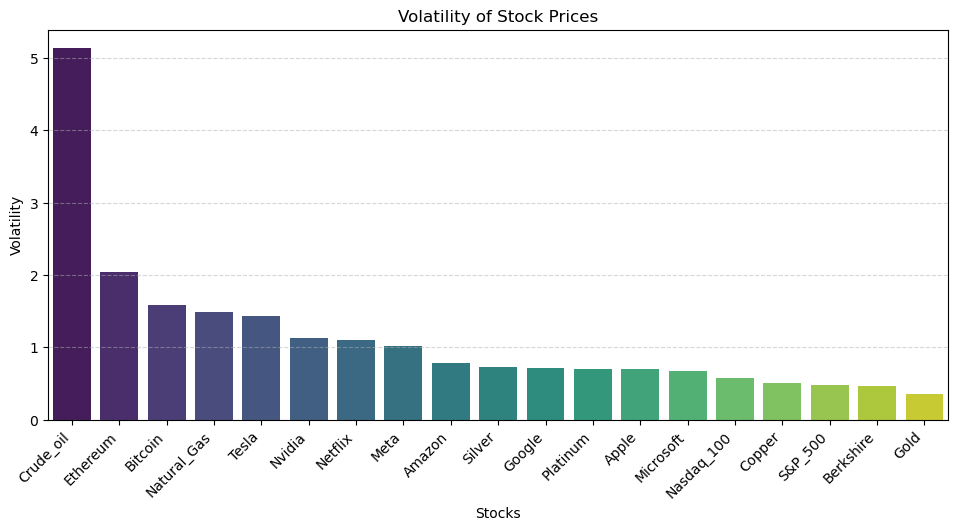

In [15]:
#for the volatilites_df, remove the _Price from the index
volatilities_df.index = volatilities_df.index.str.replace('_Price', '')
volatilities_df.sort_values(by='Volatility', ascending=False, inplace=True)

#make a bar chart of the volatilities
plt.figure(figsize=(10, 6))
sns.barplot(x=volatilities_df.index, y=volatilities_df['Volatility'], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.yticks(np.arange(0, 5.5, 0.5))
plt.title('Volatility of Stock Prices')
plt.ylabel('Volatility')
plt.xlabel('Stocks')
plt.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=1.0)
volatility = plt.gcf()
plt.show()

#save as pdf
volatility.savefig('volatility.pdf')

### Now we move on to merged both datasets
since the inflation data is 1 entry per month, and the stock data is 1 entry per day
1. we'll have to drop all the inflation data up until Febraury 2019
2. We'll take the average of the stock price for the month and create a new df

The new df will contain both S&P_500 price and inflation

In [16]:
# drop all inflation data before 2-2019
inflation_data = inflation_data.loc['2019-02-01':]

In [17]:
#create a S&P_500 df that contains 1 entry per month which represents the average price of the S&P_500 for that month
sp_500_monthly = stock_data['S&P_500_Price'].resample('M').mean()

#convert to a dataframe
sp_500_monthly = pd.DataFrame(sp_500_monthly)

#change dates to start of month
sp_500_monthly.index = sp_500_monthly.index.to_period('M').to_timestamp()

In [18]:
#create a S&P_500 df that contains 1 entry per month which represents the median price of the S&P_500 for that month
sp_500_monthly_median = stock_data['S&P_500_Price'].resample('M').median()

#convert to a dataframe
sp_500_monthly_median = pd.DataFrame(sp_500_monthly_median)

#change dates to start of month
sp_500_monthly_median.index = sp_500_monthly_median.index.to_period('M').to_timestamp()

In [19]:
#combine the 2 dataframes
sp_500_combined = pd.concat([sp_500_monthly, sp_500_monthly_median], axis=1)
sp_500_combined.columns = ['Mean', 'Median']

#round the mean and median to 3 decimal places
sp_500_combined['Mean'] = sp_500_combined['Mean'].round(3)
sp_500_combined['Median'] = sp_500_combined['Median'].round(3)

#measure the descrepancy between the mean and median in percentage
sp_500_combined['Descrepancy_%'] = ((sp_500_combined['Mean'] - sp_500_combined['Median']) / sp_500_combined['Mean']) * 100


#print mean and variance of descrepancy
print('Mean of Descrepancy:', sp_500_combined['Descrepancy_%'].mean())
print('Variance of Descrepancy:', sp_500_combined['Descrepancy_%'].var())

sp_500_combined.head()


Mean of Descrepancy: -0.16886581210972912
Variance of Descrepancy: 0.33297509985019763


,Mean,Median,Descrepancy_%
Date,,,
2019-02-01,2757.549,2763.955,-0.232308
2019-03-01,2803.984,2805.370,-0.049430
2019-04-01,2903.800,2905.030,-0.042358
2019-05-01,2854.706,2857.900,-0.111885
2019-06-01,2890.166,2890.655,-0.016919


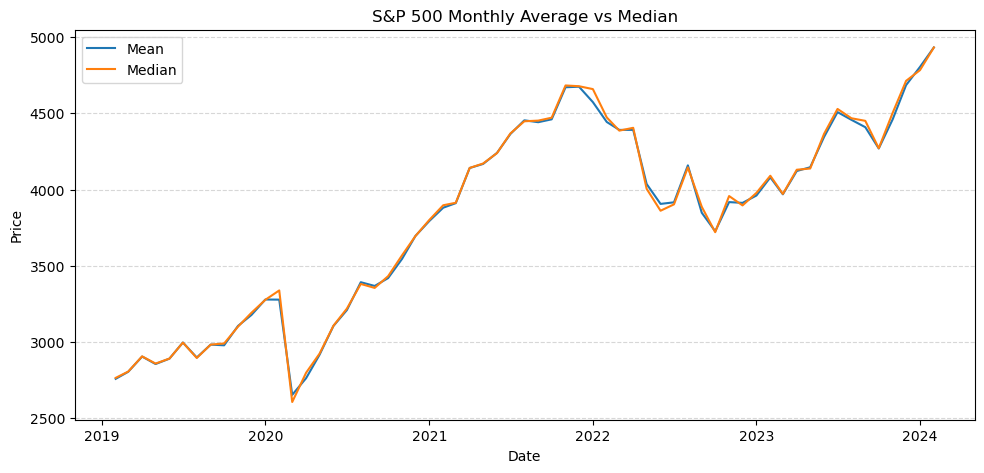

In [20]:
#compare the monthly average vs median values
plt.figure(figsize=(10, 6))
plt.plot(sp_500_combined['Mean'], label='Mean')
plt.plot(sp_500_combined['Median'], label='Median')
plt.title('S&P 500 Monthly Average vs Median')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=1.0)
sp_500 = plt.gcf()
plt.show()

#save as pdf
sp_500.savefig('sp_500_median_mean.pdf')


It can be observed from the 2 blocks above that the mean and median of the S&P 500 aren't too far off with a average descrepancy of -0.16% which implies that there's aren't any significant outlier datapoints that will skew the mean. Therefore it wouldn't cause a problem whether we represent the monthly S&P_500 price by the mean or median. so we'll continue with the mean.

In [21]:
#merge the sp_500_monthly df with the inflation data
new_df = pd.merge(sp_500_monthly, inflation_data, left_index=True, right_index=True)

#change column names
new_df.columns = ['S&P_500_Price', 'Inflation_rate_%']

new_df.tail()

,S&P_500_Price,Inflation_rate_%
Date,,
2023-10-01,4269.400909,4.0
2023-11-01,4460.062381,4.0
2023-12-01,4685.193500,3.9
2024-01-01,4804.495714,3.9
2024-02-01,4932.400000,3.8


In [22]:
#add a column for % change in S&P_500_Price
new_df['S&P_500_%_Change'] = (new_df['S&P_500_Price'].pct_change() * 100).round(3)

#add a column for difference between inflation rate and S&P_500_%_Change
new_df['Inflation-S&P_500_Desparity'] = abs(new_df['S&P_500_%_Change'] - new_df['Inflation_rate_%'])

new_df.fillna(0, inplace=True)

In [23]:
new_df.head()

,S&P_500_Price,Inflation_rate_%,S&P_500_%_Change,Inflation-S&P_500_Desparity
Date,,,,
2019-02-01,2757.549444,2.1,0.000,0.000
2019-03-01,2803.983810,2.0,1.684,0.316
2019-04-01,2903.800000,2.1,3.560,1.460
2019-05-01,2854.705909,2.0,-1.691,3.691
2019-06-01,2890.166000,2.1,1.242,0.858


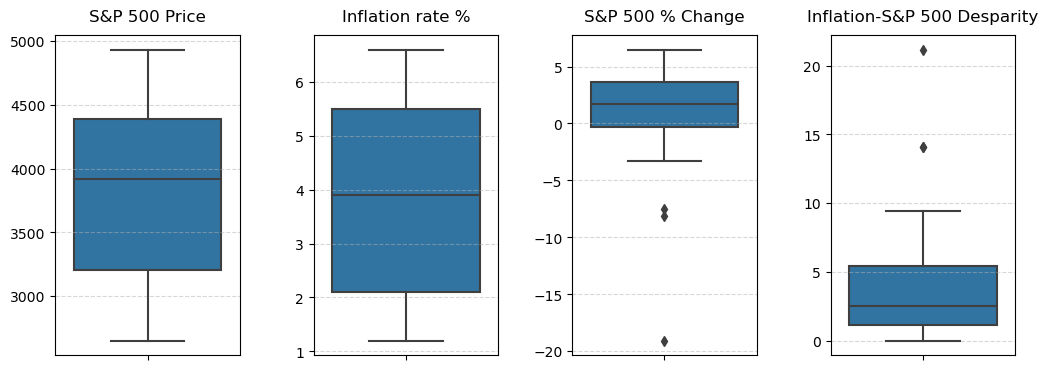

In [24]:
#generate separate boxplots for the columns in new_df
fig, axes = plt.subplots(1, len(new_df.columns), figsize=(12, 4))
fig.subplots_adjust(hspace=0.9, wspace=0.4)
axs = axes.ravel()
for i, column in enumerate(new_df.columns):
    sns.boxplot(y=new_df[column], ax=axs[i])
    axs[i].set_title(str(column).replace('_', ' '), pad=10)
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
boxplots = plt.gcf()
plt.show()

#save as pdf
boxplots.savefig('boxplots.pdf')


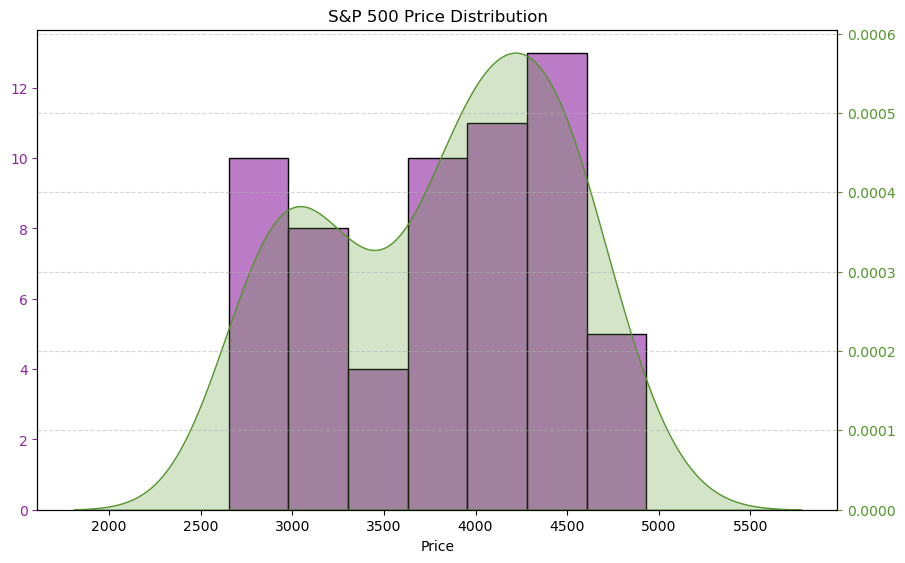

In [25]:
#plot a histogram/kde plot of the S&P_500_price

plt.figure(figsize=(10, 6))
sns.histplot(new_df['S&P_500_Price'], color='#9024a3', bins='auto',alpha=0.6)
plt.xlabel('Price')
plt.ylabel('')
plt.tick_params(axis='y', colors='#9024a3')
plt.twinx()
sns.kdeplot(new_df['S&P_500_Price'], color='#52962a', fill=True)
plt.title('S&P 500 Price Distribution')
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='y', colors='#52962a')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
histogram_SP = plt.gcf()
plt.show()

#save as pdf
histogram_SP.savefig('histogram_SP.pdf')


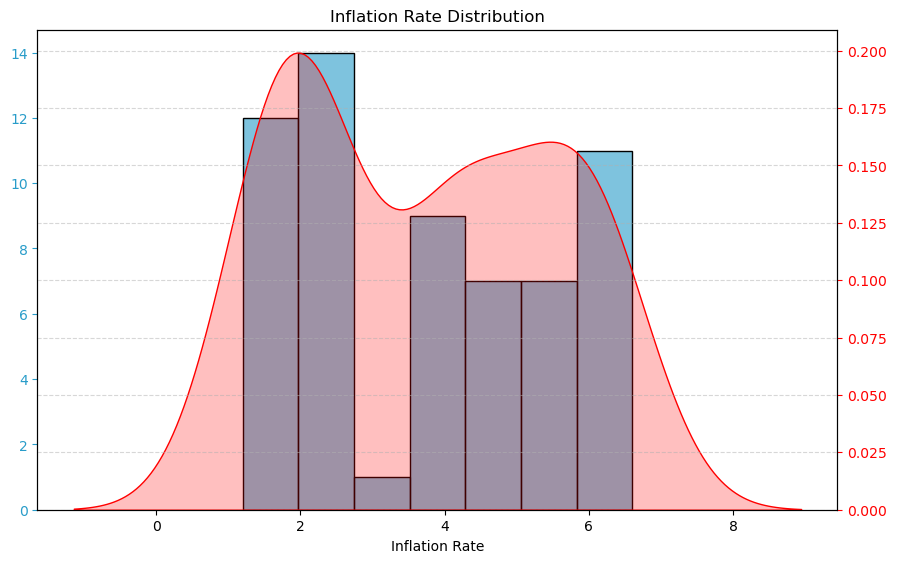

In [26]:
# create a histogram/kde plot of the inflation rate
plt.figure(figsize=(10, 6))
sns.histplot(new_df['Inflation_rate_%'], color='#289cc9', bins='auto', alpha=0.6)
plt.xlabel('Inflation Rate')
plt.ylabel('')
plt.tick_params(axis='y', colors='#289cc9')
plt.twinx()
sns.kdeplot(new_df['Inflation_rate_%'], color='red', fill=True)
plt.title('Inflation Rate Distribution')
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='y', colors='red')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
histogram_inflation = plt.gcf()
plt.show()

#save as pdf
histogram_inflation.savefig('histogram_inflation.pdf')

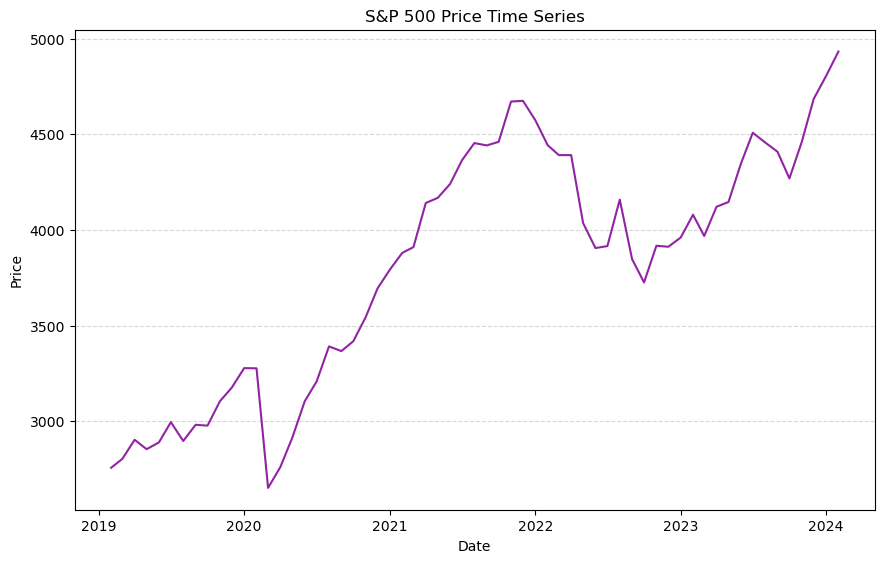

In [27]:
#plot a time series of the S&P_500_Price
plt.figure(figsize=(10, 6))
plt.plot(new_df['S&P_500_Price'], color='#9024a3')
plt.title('S&P 500 Price Time Series')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
time_series_SP = plt.gcf()
plt.show()

#save as pdf
time_series_SP.savefig('time_series_SP.pdf')


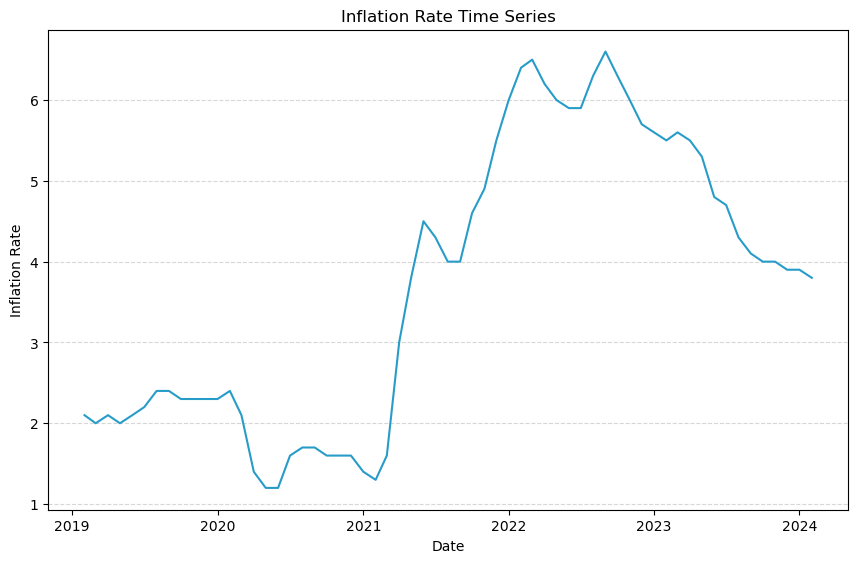

In [28]:
#plot a time series of inflation rate
plt.figure(figsize=(10, 6))
plt.plot(new_df['Inflation_rate_%'], color='#289cc9')
plt.title('Inflation Rate Time Series')
plt.ylabel('Inflation Rate')
plt.xlabel('Date')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
time_series_inflation = plt.gcf()
plt.show()

#save as pdf
time_series_inflation.savefig('time_series_inflation.pdf')

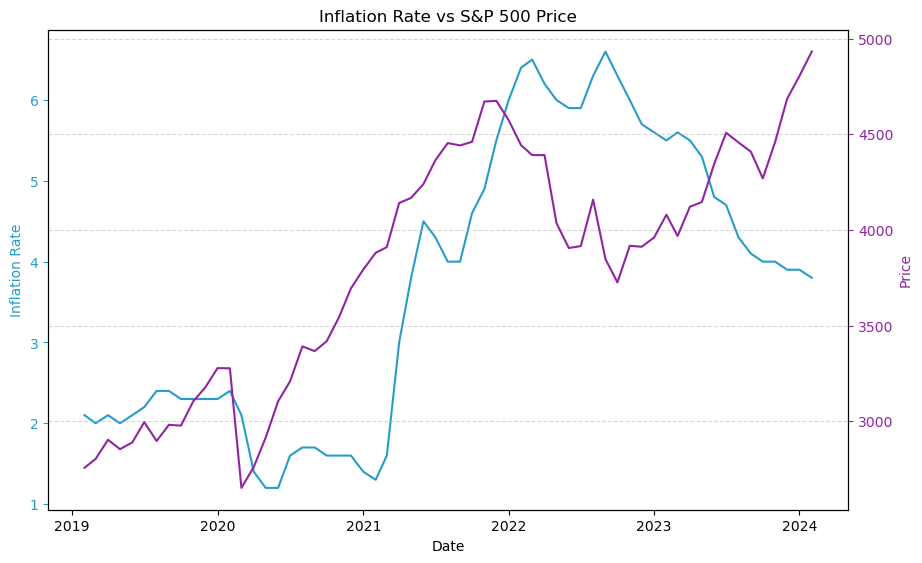

In [29]:
#plot a time series of inflation rate and S&P_500_Price
plt.figure(figsize=(10, 6))
plt.plot(new_df['Inflation_rate_%'], color='#289cc9', label='Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Inflation Rate', color='#289cc9')
plt.tick_params(axis='y', colors='#289cc9')
plt.twinx()
plt.plot(new_df['S&P_500_Price'], color='#9024a3', label='S&P 500 Price')
plt.ylabel('Price', color='#9024a3')
plt.tick_params(axis='y', colors='#9024a3')
plt.title('Inflation Rate vs S&P 500 Price')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
time_series_dual = plt.gcf()
plt.show()

#save as pdf
time_series_dual.savefig('time_series_dual.pdf')


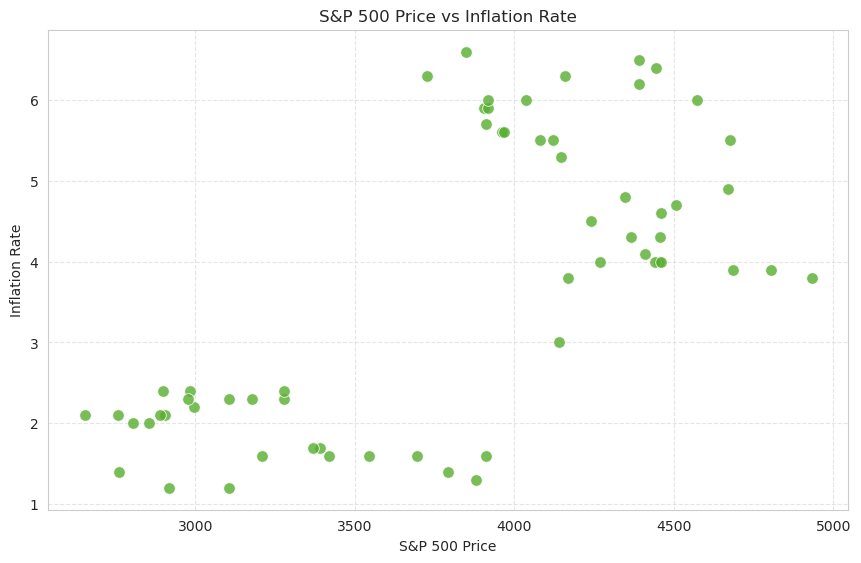

In [30]:
#scatter plot of S&P_500_Price vs Inflation_rate_%
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.scatterplot(x=new_df['S&P_500_Price'], y=new_df['Inflation_rate_%'], color='#57ad2f', s=70, alpha=0.8)
plt.title('S&P 500 Price vs Inflation Rate')
plt.xlabel('S&P 500 Price')
plt.ylabel('Inflation Rate')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
scatter_SP_inflation = plt.gcf()
plt.show()

#save as pdf
scatter_SP_inflation.savefig('scatter_SP_inflation.pdf')

# Part II: Formulate your hypothesis and perform hypothesis testing

**H0:** We cannot predict the market inflation by looking at the changes in price of the S&P 500

**H1:** We can predict... (Not H0).

This means that if we get a correlation coefficient that is higher than the correlation coefficient resulting in alpha=0.1, then we are in the critical region, and we reject the Null hypothesis in favor of the alternate hypothesis. (this will be determined by observing the p-values)

##### Important question:
How many months ahead is the prediction most accurate? In other words, how far in advance does the S&P 500 predict inflation?

## Methodology:
1. I will create 12 dataframes, I will shift the months by 1 in each. *(df_0 is normal, df_1 will have one month ahead inflation values, etc..)*
    
    for each df:

    a. dual time-series graph to observe the similarity

    b. scatterplot

    c. pearson correlation (statistic of choice)

    d. p-value

    all of these will be saved into results df

2. results df will be studied, hypothesis conclusion will be made based on the p-value ***(alpha = 0.1)***

In [31]:
#function to shift the dataframe by a specified number
def shift_df(df: pd.DataFrame, shift_by: int):

    df = df.copy()
    df['S&P_500_Price'] = df['S&P_500_Price'].shift(shift_by)
    df['S&P_500_%_Change'] = df['S&P_500_%_Change'].shift(shift_by)

    #drop na rows
    df.dropna(inplace=True)
    
    return df

In [32]:
#functions to manage each df

def scatterplot_function(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')
    sns.scatterplot(x=df['S&P_500_Price'], y=df['Inflation_rate_%'], color='#57ad2f', s=70, alpha=0.8)
    plt.title(title)
    plt.xlabel('S&P 500 Price')
    plt.ylabel('Inflation Rate')
    plt.grid(axis='both', linestyle='--', alpha=0.5)
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
    scatter = plt.gcf()
    plt.show()
    return scatter


def dual_time_series_function(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Inflation_rate_%'], color='#289cc9', label='Inflation Rate')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate', color='#289cc9')
    plt.tick_params(axis='y', colors='#289cc9')
    plt.twinx()
    plt.plot(df['S&P_500_Price'], color='#9024a3', label='S&P 500 Price')
    plt.ylabel('Price', color='#9024a3')
    plt.tick_params(axis='y', colors='#9024a3')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
    time_series = plt.gcf()
    plt.show()
    return time_series


def hypothesis_values(df: pd.DataFrame):
    return stats.pearsonr(df['S&P_500_Price'], df['Inflation_rate_%'])


In [33]:
#test all the shift levels from 0 to 11 and see which one has the highest correlation

results = []

for x in range(12):
    df = shift_df(new_df, x)
    result = hypothesis_values(df)
    summary = {
        "Correlation": result[0],
        "P-value": result[1],
        "shift": x
    }
    results.append(summary)


#convert results to a dataframe
results_df = pd.DataFrame(results)

results_df

,Correlation,P-value,shift
0,0.675436,2.355623e-09,0
1,0.725902,5.295923e-11,1
2,0.763252,2.096243e-12,2
3,0.794029,1.036548e-13,3
4,0.817315,8.806770e-15,4
5,0.839533,6.295722e-16,5
6,0.862595,2.597116e-17,6
7,0.885620,5.906922e-19,7
8,0.908078,6.435731e-21,8
9,0.915386,2.135743e-21,9


In [34]:
#sort results_df by highets correlation
results_df.sort_values(by='Correlation', ascending=False, inplace=True)

results_df

,Correlation,P-value,shift
9,0.915386,2.135743e-21,9
8,0.908078,6.435731e-21,8
10,0.907051,4.853067e-20,10
7,0.885620,5.906922e-19,7
11,0.882724,2.326572e-17,11
6,0.862595,2.597116e-17,6
5,0.839533,6.295722e-16,5
4,0.817315,8.806770e-15,4
3,0.794029,1.036548e-13,3
2,0.763252,2.096243e-12,2


It can be observed from the table above the best shift-value is 9 as it produces a correlation coefficient of 0.91 with a very low p-value implying that our test is very significant.

What this means is that we will reject the Null hypothesis in favor of the alternate which implies that we can predict inflation using changes in S&P_500 price.

Furthermore, the current S&P_500 price changes best predict inflation 9-months from now.

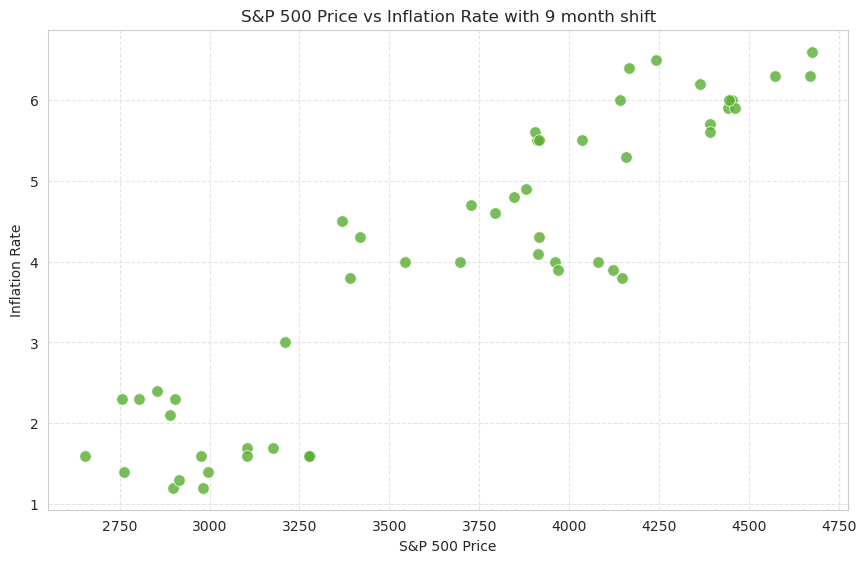

In [35]:
#regenerate the df with the best correlation
best_df = shift_df(new_df, 9)

#scatter plot of S&P_500_Price vs Inflation_rate_% with the best correlation
x = scatterplot_function(best_df, 'S&P 500 Price vs Inflation Rate with 9 month shift')

x.savefig('scatter_best.pdf')

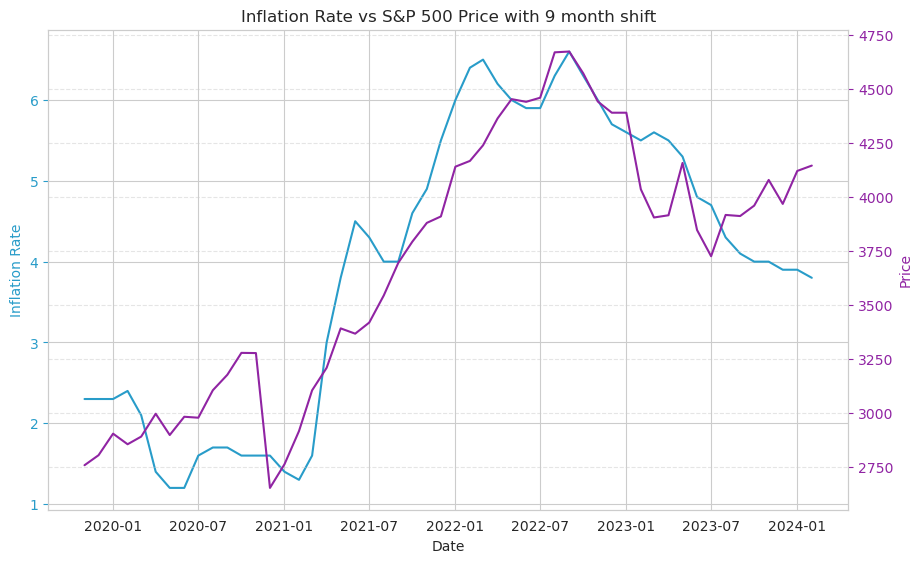

In [36]:
#time series of S&P_500_Price vs Inflation_rate_% with the best correlation
y = dual_time_series_function(best_df, 'Inflation Rate vs S&P 500 Price with 9 month shift')

y.savefig('time_series_best.pdf')

# Part III: Build a linear regression model for prediction

A linear regression model will be built here, it will be shown on a scatter plot.

20% of the data will be used for testing

In [37]:
#new imports

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

In [38]:
#normalise the S&P_500_Price and Inflation_rate_% columns
best_df['S&P_500_Price'] = (best_df['S&P_500_Price'] - best_df['S&P_500_Price'].mean()) / best_df['S&P_500_Price'].std()
best_df['Inflation_rate_%'] = (best_df['Inflation_rate_%'] - best_df['Inflation_rate_%'].mean()) / best_df['Inflation_rate_%'].std()

In [39]:
#extracting the input and output vectors
y = best_df['Inflation_rate_%'].values.reshape(-1,1)
X = best_df['S&P_500_Price'].values.reshape(-1,1)

# trai-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [40]:
#creating the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [41]:
#intercept
b = model.intercept_
bf = b[0].round(2)
#slope
m = model.coef_
mf = m[0][0].round(2)

print(f'The intercept is: {bf}')
print(f'The slope is: {mf}\n')
print(f'Equation is: y = {mf}x {bf}\n')
print(f'Inflation_rate = ({mf} * S&P_500 price) {bf}\n')

#print(f'Therefore,')
#print(f'Inflation_rate = (S&P_500P - {bf}) / {mf}\n')

The intercept is: -0.01
The slope is: 0.89

Equation is: y = 0.89x -0.01

Inflation_rate = (0.89 * S&P_500 price) -0.01



In [42]:
#I forgot to add this, this is after the fact

model.predict(X_test)

#then here you get the r2 score and report it

r2 = r2_score(y_test, model.predict(X_test))
r2

0.8698137510443282

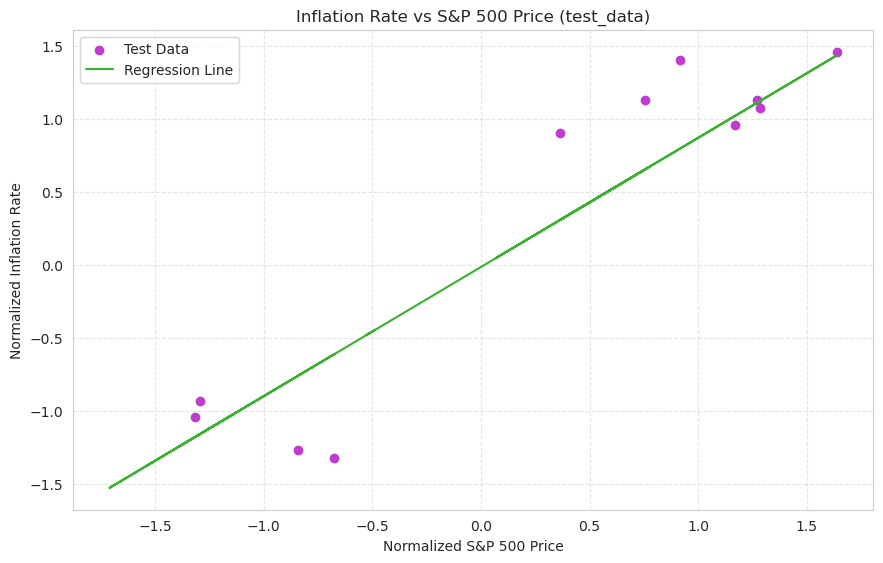

In [43]:
#graph with test data
rline = m[0]*X.flatten() + b

#r2 is the same as the one above

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='#c03ccf', label='Test Data')
plt.plot(X.flatten(), rline, color='#37b32e', label='Regression Line')
plt.title('Inflation Rate vs S&P 500 Price (test_data)')
plt.xlabel('Normalized S&P 500 Price')
plt.ylabel('Normalized Inflation Rate')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
regression_line = plt.gcf()
plt.show()

#save as pdf
regression_line.savefig('regression_line_test_scatter.pdf')

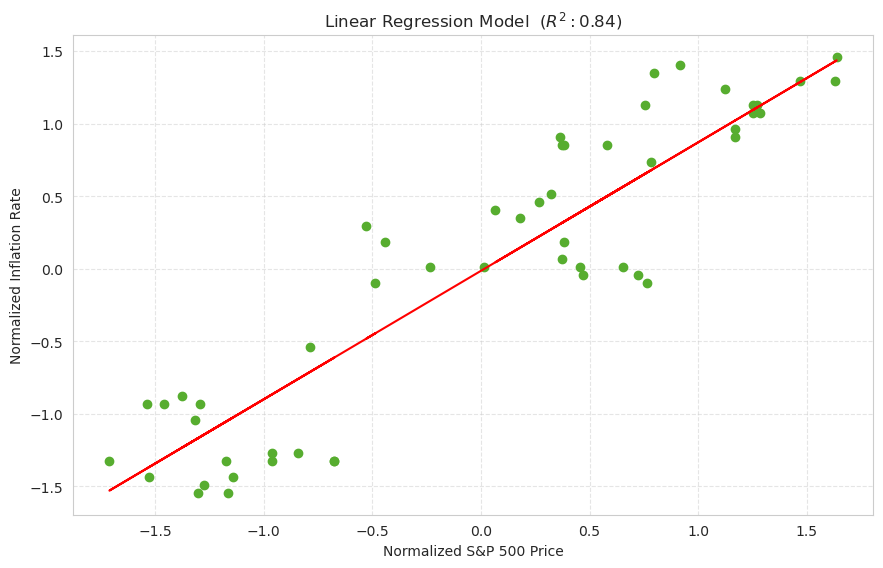

In [44]:
#resulting regression line
rline = m[0]*X.flatten() + b

#find the r2 score
r2 = model.score(X, y).round(2)
r2 = r"$R^2: {:.2f}$".format(r2)

#plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='#57ad2f')
plt.plot(X.flatten(), rline, color='red')
plt.title(fr'Linear Regression Model  ({r2})')
plt.ylabel('Normalized Inflation Rate')
plt.xlabel('Normalized S&P 500 Price')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
regression_line = plt.gcf()
plt.show()

#save as pdf
regression_line.savefig('regression_line.pdf')

In [45]:
#r2 score for training data because it's nice to see
r2_train = r2_score(y_train, model.predict(X_train))

#r2 score for test data
r2_train

0.8177812358117897

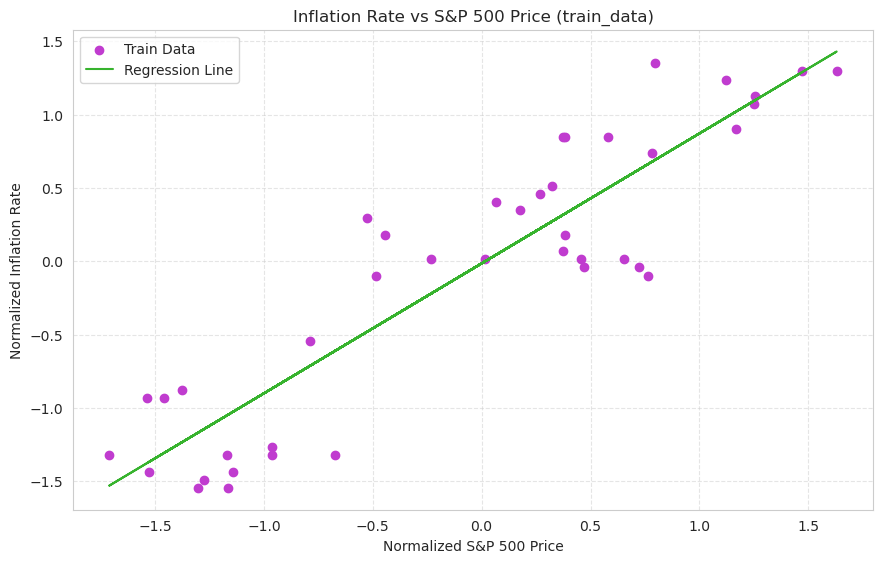

In [46]:
#graph
rline = m[0]*X_train.flatten() + b

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='#c03ccf', label='Train Data')
plt.plot(X_train.flatten(), rline, color='#37b32e', label='Regression Line')
plt.title('Inflation Rate vs S&P 500 Price (train_data)')
plt.xlabel('Normalized S&P 500 Price')
plt.ylabel('Normalized Inflation Rate')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)
regression_line_train = plt.gcf()
plt.show()

#save as pdf
regression_line_train.savefig('regression_line_train.pdf')

In [50]:
#rmse of the model
mse = metrics.mean_squared_error(y_test, model.predict(X_test))
sqrt(mse)

0.4035371990715073